# Benchmarking Against LCU Block-Encodings

In [1]:
from openparticle import ParticleOperator
import numpy as np
import cirq
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../../../'))
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../../'))
from src.lobe.system import System
from src.lobe.lcu import LCU
from colors import *
from openparticle import generate_matrix
from src.lobe._utils import get_basis_of_full_system, pretty_print, get_bosonic_exponents
from src.lobe.asp import get_target_state, add_prepare_circuit
from src.lobe.rescale import rescale_coefficients
from src.lobe.index import index_over_terms
from src.lobe.metrics import CircuitMetrics
from src.lobe.bosonic import bosonic_product_block_encoding, bosonic_product_plus_hc_block_encoding 
from functools import partial
from tests._utils import _validate_block_encoding

/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-04 11:33:12,208	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
def naive_lcu(operator, max_bosonic_occupancy):
    lcu = LCU(operator, max_bosonic_occupancy=max_bosonic_occupancy, zero_threshold=1e-9)
    ctrls = ([cirq.LineQubit(-1000000)], [1])
    circuit = cirq.Circuit()
    circuit.append(cirq.X.on(ctrls[0][0]))
    lcu_circuit = lcu.get_circuit(ctrls=ctrls)
    circuit += lcu_circuit
    circuit.append(cirq.X.on(ctrls[0][0]))
    fake_sys = System(operator.max_mode + 1, max_bosonic_occupancy, 1000 + lcu.number_of_index_qubits, operator.has_fermions, operator.has_antifermions, operator.has_bosons)

    if max_bosonic_occupancy < 31:
        _validate_block_encoding(circuit, fake_sys, lcu.one_norm, operator, len(lcu.index_register), max_bosonic_occupancy, max_qubits=16, using_pytest=False)

    return lcu.circuit_metrics, lcu.one_norm, len(lcu.index_register)

In [3]:
from copy import deepcopy

def get_lcu_helper(operator, system, block_encoding_ancillae, clean_ancillae):
    term = deepcopy(operator)
    assert term.coeff == 1
    assert len(term.to_list()) == 1
    assert len(block_encoding_ancillae) >= len(term.split()) * 3

    estimated_rescaling_factor = 1
    for op in term.split():
        lcu = LCU(op, max_bosonic_occupancy=system.maximum_occupation_number, zero_threshold=1e-9)
        estimated_rescaling_factor *= lcu.one_norm


    def _lcu_helper(ctrls=([], [])):
        _circuit = cirq.Circuit()
        _metrics = CircuitMetrics()
        overall_rescaling_factor = 1

        for i, op in enumerate(term.split()):
            new_op = ParticleOperator({((2, 0, list(op.op_dict.keys())[0][0][2]),): 1})
            lcu = LCU(new_op, max_bosonic_occupancy=system.maximum_occupation_number, zero_threshold=1e-9)
            assert lcu.number_of_index_qubits == 3
            assert len(system.bosonic_system[op.mode]) == 2
            lcu.index_register = block_encoding_ancillae[i*3:(i+1)*3]
            lcu.system_register = system.bosonic_system[op.mode]
            lcu.clean_ancillae = clean_ancillae
            
            _circuit += lcu.get_circuit(ctrls=ctrls)
            _metrics += lcu.circuit_metrics
            overall_rescaling_factor *= lcu.one_norm

        assert np.isclose(estimated_rescaling_factor, overall_rescaling_factor)
        return _circuit, _metrics
    
    return _lcu_helper, estimated_rescaling_factor

def lcu_piecewise(operator, max_bosonic_occupancy):

    number_of_be_ancillae = (operator.max_mode + 1) * 3

    ctrls = ([cirq.LineQubit(-1000000)], [1])
    index_register = [cirq.LineQubit(-i - 2) for i in range(int(np.ceil(np.log2(len(operator.to_list())))))]
    block_encoding_ancillae = [cirq.LineQubit(-100 - i - len(index_register)) for i in range(number_of_be_ancillae)]
    ctrls = ([cirq.LineQubit(0)], [1])
    clean_ancillae = [cirq.LineQubit(i + 100) for i in range(100)]
    system = System(operator.max_mode + 1,
                    max_bosonic_occupancy,
                    1000,
                    operator.has_fermions,
                    operator.has_antifermions,
                    operator.has_bosons
    )

    rescaling_factors, block_encoding_functions = [], []
    for term in operator.to_list():
        be_function, rescaling_factor = get_lcu_helper(
            term, system, block_encoding_ancillae, clean_ancillae=clean_ancillae[::-1]
        )
        rescaling_factors.append(rescaling_factor)
        block_encoding_functions.append(be_function)

    rescaled_coefficients, overall_rescaling_factor = rescale_coefficients(
        [term.coeffs[0] for term in operator.to_list()],
        rescaling_factors
    )
    print(rescaling_factors, overall_rescaling_factor)
    target_state = get_target_state(rescaled_coefficients)
    
    # Generate Circuit
    gates = []
    metrics = CircuitMetrics()

    gates.append(cirq.X.on(ctrls[0][0]))
    _gates, _metrics = add_prepare_circuit(index_register, target_state, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = index_over_terms(index_register, block_encoding_functions, clean_ancillae, ctrls=ctrls)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = add_prepare_circuit(index_register, target_state, dagger=True, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics
    gates.append(cirq.X.on(ctrls[0][0]))

    circuit = cirq.Circuit(gates)
    _validate_block_encoding(circuit, system, overall_rescaling_factor, operator, len(index_register) + number_of_be_ancillae, max_bosonic_occupancy, max_qubits=16, using_pytest=False)

    return  metrics, overall_rescaling_factor, len(index_register) + number_of_be_ancillae

In [4]:
def lobotomize(operator, max_bosonic_occupancy):
    active_indices, exponents_list = get_bosonic_exponents(operator.to_list()[0])
    number_of_be_ancillae = len(active_indices)

    expected_rescaling_factor = 1
    for exponents in exponents_list:
        if exponents != (0, 0):
            expected_rescaling_factor *= (np.sqrt(max_bosonic_occupancy))**sum(exponents)

    if len(operator) == 1:
        be_func = bosonic_product_block_encoding
    else:
        be_func = bosonic_product_plus_hc_block_encoding
        number_of_be_ancillae += 1
        expected_rescaling_factor *= 2

    ctrls = ([cirq.LineQubit(-1000000)], [1])
    clean_ancillae = [cirq.LineQubit(-i-1) for i in range(100)]
    block_encoding_ancillae = [cirq.LineQubit(0 + i) for i in range(number_of_be_ancillae)]
    circuit = cirq.Circuit()
    system = System(len(active_indices), max_bosonic_occupancy, 1000, operator.has_fermions, operator.has_antifermions, operator.has_bosons)
    circuit.append(cirq.X.on(ctrls[0][0]))
    gates, metrics = be_func(
        system,
        block_encoding_ancillae,
        active_indices=active_indices,
        exponents_list=exponents_list,
        clean_ancillae=clean_ancillae,
        ctrls=ctrls
    )
    circuit += gates
    circuit.append(cirq.X.on(ctrls[0][0]))
    if max_bosonic_occupancy < 31:
        _validate_block_encoding(circuit,
            system,
            expected_rescaling_factor,
            operator,
            number_of_be_ancillae,
            max_bosonic_occupancy,
            max_qubits=16,
            using_pytest=False
        )
    return metrics, expected_rescaling_factor, number_of_be_ancillae

## Scaling of Single Operator with $\Omega$

In [5]:
def _2_norm(operator, max_bosonic_occupancy):
    full_fock_basis = get_basis_of_full_system(
        operator.max_mode + 1,
        max_bosonic_occupancy,
        has_fermions=False,
        has_antifermions=False,
        has_bosons=True,
    )
    expected_unitary = generate_matrix(operator, full_fock_basis)
    return np.linalg.norm(expected_unitary, ord=2)

def _max_column_norm(operator, max_bosonic_occupancy):
    full_fock_basis = get_basis_of_full_system(
        operator.max_mode + 1,
        max_bosonic_occupancy,
        has_fermions=False,
        has_antifermions=False,
        has_bosons=True,
    )
    expected_unitary = generate_matrix(operator, full_fock_basis)

    max_column_norm = 0
    for i in range(expected_unitary.shape[0]):
        column = expected_unitary[:, i]
        column_norm = 0
        for val in column:
            column_norm += np.abs(val)**2
        column_norm = np.sqrt(column_norm)
        max_column_norm = max(column_norm, max_column_norm)
        
    return max_column_norm

In [6]:
omegas = [1, 3, 7, 15, 31]

LCU_DATA = []
LOBE_DATA = []
operator_norms = []
max_column_norms = []

operator = ParticleOperator("a0")

for omega in omegas:
    print(f"-------{omega}------")

    print("LCU")
    LCU_DATA.append(naive_lcu(operator, omega))
    print("LOBE")
    LOBE_DATA.append(lobotomize(operator, omega))

    operator_norms.append(_2_norm(operator, omega))
    max_column_norms.append(_max_column_norm(operator, omega))

-------1------
LCU
LOBE
-------3------
LCU
LOBE
-------7------
LCU
LOBE
-------15------
LCU
Testing singular quantum state for circuit with 12 qubits
0.9999998648071712
LOBE
-------31------
LCU
LOBE


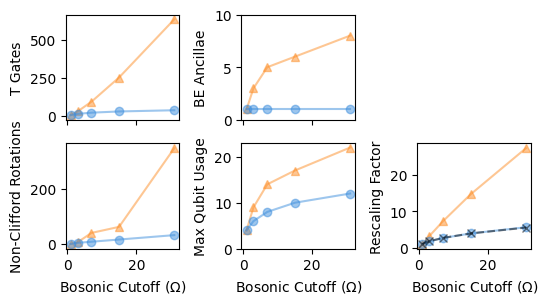

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(14 / 2.54, 8 / 2.54))

axes[0][0].plot(omegas, [(4*LCU_DATA[i][0].number_of_elbows) + LCU_DATA[i][0].number_of_t_gates for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5)
axes[0][0].plot(omegas, [(4*LOBE_DATA[i][0].number_of_elbows) + LOBE_DATA[i][0].number_of_t_gates for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5)
axes[0][0].set_ylabel("T Gates")
axes[0][0].set_xticklabels([])

axes[1][0].plot(omegas, [LCU_DATA[i][0].number_of_nonclifford_rotations for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5)
axes[1][0].plot(omegas, [LOBE_DATA[i][0].number_of_nonclifford_rotations for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5)
axes[1][0].set_ylabel("Non-Clifford Rotations")
axes[1][0].set_xlabel("Bosonic Cutoff ($\Omega$)")

axes[0][1].plot(omegas, [LCU_DATA[i][2] for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5)
axes[0][1].plot(omegas, [LOBE_DATA[i][2] for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5)
axes[0][1].set_ylabel("BE Ancillae")
axes[0][1].set_xticklabels([])
axes[0][1].set_yticks([0, 5, 10])

axes[1][1].plot(omegas, [LCU_DATA[i][0].ancillae_highwater() + LCU_DATA[i][2] + int(np.ceil(np.log2(omegas[i]+1))) + 1 for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5, label="LCU")
axes[1][1].plot(omegas, [LOBE_DATA[i][0].ancillae_highwater() + LOBE_DATA[i][2] + int(np.ceil(np.log2(omegas[i]+1))) + 1 for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5, label="LOBE")
axes[1][1].plot([], [], color="black", marker='x', ls='--', alpha = 0.5, label="Hamiltonian Norm")
axes[1][1].set_ylabel("Max Qubit Usage")
axes[1][1].set_xlabel("Bosonic Cutoff ($\Omega$)")
axes[1][1].set_yticks([0, 10, 20])

axes[1][2].plot(omegas, [LCU_DATA[i][1] for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5)
axes[1][2].plot(omegas, [LOBE_DATA[i][1] for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5)
axes[1][2].plot(omegas, operator_norms, color="black", marker='x', ls='--', alpha = 0.5, label="Hamiltonian Norm")
axes[1][2].set_ylabel("Rescaling Factor")
axes[1][2].set_xlabel("Bosonic Cutoff ($\Omega$)")


fig.delaxes(axes[0][2])
plt.tight_layout()
# axes[0][1].legend(loc='upper center', bbox_to_anchor=(1.5, 0.75),
#           fancybox=True, shadow=True, ncol=1)
plt.savefig("../../../manuscript/figures/bosonic-comparison.pdf", dpi=300)

## Scaling of Operator with Number of Active Modes

In [8]:
omega = 3
numbers_of_active_modes = range(1, 5)

LCU_DATA = []
LCU_PIECEWISE_DATA = []
LOBE_DATA = []

operator_norms = []
max_column_norms = []

for number_of_active_modes in numbers_of_active_modes:
    print(f"-------{number_of_active_modes}------")
    operator = ParticleOperator("")
    for mode in range(number_of_active_modes):
        operator *= ParticleOperator(f"a{mode}")
    operator += operator.dagger()

    print("LCU - Naive")
    LCU_DATA.append(naive_lcu(operator, omega))
    print("LCU - Piecewise")
    LCU_PIECEWISE_DATA.append(lcu_piecewise(operator, omega))
    print("LOBE")
    LOBE_DATA.append(lobotomize(operator, omega))
    
    operator_norms.append(_2_norm(operator, omega))
    max_column_norms.append(_max_column_norm(operator, omega))

-------1------
LCU - Naive
LCU - Piecewise
[3.1462643699419726, 3.1462643699419726] 6.292528739883945
LOBE
-------2------
LCU - Naive
LCU - Piecewise
[9.898979485566358, 9.898979485566358] 19.797958971132715
Testing singular quantum state for circuit with 14 qubits
1.0000000496479127
LOBE
-------3------
LCU - Naive
Too many qubits to validate: 16
LCU - Piecewise
[31.144806454223946, 31.144806454223946] 62.28961290844789
Too many qubits to validate: 19
LOBE
Testing singular quantum state for circuit with 14 qubits
1.0000000006924896
-------4------
LCU - Naive
Too many qubits to validate: 21
LCU - Piecewise
[97.98979485566359, 97.98979485566359] 195.97958971132718
Too many qubits to validate: 24
LOBE
Too many qubits to validate: 17


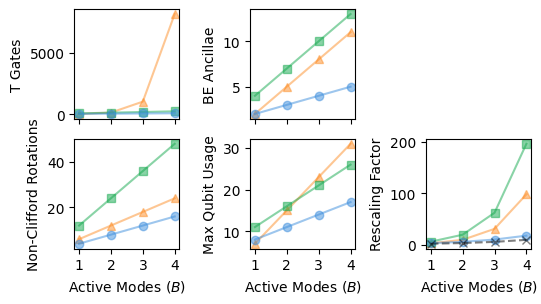

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(14 / 2.54, 8 / 2.54))

axes[0][0].plot(numbers_of_active_modes, [(4*LCU_DATA[i][0].number_of_elbows) + LCU_DATA[i][0].number_of_t_gates for i in range(len(numbers_of_active_modes))], color=ORANGE, marker='^', alpha = 0.5)
axes[0][0].plot(numbers_of_active_modes, [(4*LCU_PIECEWISE_DATA[i][0].number_of_elbows) + LCU_PIECEWISE_DATA[i][0].number_of_t_gates for i in range(len(numbers_of_active_modes))], color=GREEN, marker='s', alpha = 0.5)
axes[0][0].plot(numbers_of_active_modes, [(4*LOBE_DATA[i][0].number_of_elbows) + LOBE_DATA[i][0].number_of_t_gates for i in range(len(numbers_of_active_modes))], color=BLUE, marker='o', alpha = 0.5)
axes[0][0].set_ylabel("T Gates")
axes[0][0].set_xticks([1, 2, 3, 4])
axes[0][0].set_xticklabels([])

axes[1][0].plot(numbers_of_active_modes, [LCU_DATA[i][0].number_of_nonclifford_rotations for i in range(len(numbers_of_active_modes))], color=ORANGE, marker='^', alpha = 0.5)
axes[1][0].plot(numbers_of_active_modes, [LCU_PIECEWISE_DATA[i][0].number_of_nonclifford_rotations for i in range(len(numbers_of_active_modes))], color=GREEN, marker='s', alpha = 0.5)
axes[1][0].plot(numbers_of_active_modes, [LOBE_DATA[i][0].number_of_nonclifford_rotations for i in range(len(numbers_of_active_modes))], color=BLUE, marker='o', alpha = 0.5)
axes[1][0].set_ylabel("Non-Clifford Rotations")
axes[1][0].set_xlabel("Active Modes ($B$)")
axes[1][0].set_xticks([1, 2, 3, 4])

axes[0][1].plot(numbers_of_active_modes, [LCU_DATA[i][2] for i in range(len(numbers_of_active_modes))], color=ORANGE, marker='^', alpha = 0.5)
axes[0][1].plot(numbers_of_active_modes, [LCU_PIECEWISE_DATA[i][2] for i in range(len(numbers_of_active_modes))], color=GREEN, marker='s', alpha = 0.5)
axes[0][1].plot(numbers_of_active_modes, [LOBE_DATA[i][2] for i in range(len(numbers_of_active_modes))], color=BLUE, marker='o', alpha = 0.5)
axes[0][1].set_ylabel("BE Ancillae")
# axes[0][1].set_yticks([0, 5, 10])
axes[0][1].set_xticks([1, 2, 3, 4])
axes[0][1].set_xticklabels([])

axes[1][2].plot(numbers_of_active_modes, [LCU_DATA[i][1] for i in range(len(numbers_of_active_modes))], color=ORANGE, marker='^', alpha = 0.5)
axes[1][2].plot(numbers_of_active_modes, [LCU_PIECEWISE_DATA[i][1] for i in range(len(numbers_of_active_modes))], color=GREEN, marker='s', alpha = 0.5)
axes[1][2].plot(numbers_of_active_modes, [LOBE_DATA[i][1] for i in range(len(numbers_of_active_modes))], color=BLUE, marker='o', alpha = 0.5)
axes[1][2].plot(numbers_of_active_modes, operator_norms, color="black", marker='x', ls='--', alpha = 0.5, label="Hamiltonian Norm")
axes[1][2].set_ylabel("Rescaling Factor")
axes[1][2].set_xlabel("Active Modes ($B$)")
axes[1][2].set_xticks([1, 2, 3, 4])

axes[1][1].plot(numbers_of_active_modes, [LCU_DATA[i][0].ancillae_highwater() + LCU_DATA[i][2] + (numbers_of_active_modes[i]*int(np.ceil(np.log2(omega)))) + 1 for i in range(len(numbers_of_active_modes))], color=ORANGE, marker='^', alpha = 0.5, label="LCU")
axes[1][1].plot(numbers_of_active_modes, [LCU_PIECEWISE_DATA[i][0].ancillae_highwater() + LCU_PIECEWISE_DATA[i][2] + (numbers_of_active_modes[i]*int(np.ceil(np.log2(omega)))) + 1 for i in range(len(numbers_of_active_modes))], color=GREEN, marker='s', alpha = 0.5, label="LCU")
axes[1][1].plot(numbers_of_active_modes, [LOBE_DATA[i][0].ancillae_highwater() + LOBE_DATA[i][2] + (numbers_of_active_modes[i]*int(np.ceil(np.log2(omega)))) + 1 for i in range(len(numbers_of_active_modes))], color=BLUE, marker='o', alpha = 0.5, label="LOBE")
axes[1][1].set_ylabel("Max Qubit Usage")
# axes[1][1].set_yticks([0, 10, 20])
axes[1][1].set_xlabel("Active Modes ($B$)")
axes[1][1].set_xticks([1, 2, 3, 4])

fig.delaxes(axes[0][2])
plt.tight_layout()
plt.savefig("../../../manuscript/figures/bosonic-hc-comparison.pdf", dpi=300)